# Resnet Model Notebook

This notebook shows the ResNet Model applied to the Global View Dataset.

### 1. Installs and Imports

In [ ]:
!pip install tsai 

In [ ]:
from tsai.all import *
import pandas as pd
import sklearn.metrics as skm
from scipy import signal

### 2. Processing

In [ ]:
global_view = pd.read_csv('Full Global View Data.csv')
global_view = global_view.drop(columns=["Unnamed: 0"])
global_view

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0.805089,1.014019,0.879615,0.740667,1.078750,1.079406,1.205584,1.016628,0.998133,0.807200,...,1.057726,1.022003,1.160232,0.824003,0.982633,0.935857,0.936493,1.172365,1.051194,1
1,1.024147,1.022181,1.019334,1.014465,1.005740,0.994486,0.992549,1.009373,1.027504,1.036873,...,1.023391,1.028558,1.033152,1.037896,1.028911,1.015798,1.004923,1.009685,1.017351,0
2,1.177299,1.189832,1.327257,1.206747,1.099294,1.008407,0.956516,0.962503,0.983430,0.962339,...,1.106324,1.242909,1.114947,0.954955,0.958157,0.953832,0.913456,0.877882,1.117244,1
3,1.016976,0.996287,0.942826,0.993312,0.988428,1.002230,0.846147,1.037384,1.117179,1.217264,...,1.049267,0.858152,1.005960,0.875383,1.010819,0.973698,1.185194,1.011624,1.109986,1
4,0.899222,1.008320,0.955359,0.988199,0.794748,0.659896,0.742937,0.921260,0.843183,0.795844,...,1.130554,1.112823,1.151438,0.985616,1.108118,1.091524,1.215078,1.051907,0.997601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.994224,0.997571,0.993460,0.990148,0.992702,0.995424,0.994811,0.991220,0.992966,1.001081,...,0.994400,0.989497,0.987133,0.994495,0.999678,1.001759,1.001121,0.993380,0.988747,1
451,0.961073,0.984563,0.925543,0.941521,0.949315,0.990593,1.069938,1.023916,1.008956,0.957805,...,1.002177,1.025846,1.001176,0.949222,0.952527,0.962821,0.932300,0.924307,0.998634,1
452,1.062949,1.150878,1.106013,1.103070,1.073420,1.063598,1.037858,1.025627,1.001151,0.992435,...,0.954795,0.957703,0.954115,0.960708,0.954982,0.964284,0.954554,0.970666,0.946162,1
453,0.970285,0.915315,1.031886,1.051039,0.970926,1.094397,0.993410,1.037287,1.034228,1.005614,...,1.007761,0.923017,0.999288,0.967330,0.962120,1.032110,0.987394,0.925149,0.996282,0


In [ ]:
# TRAIN-VALID DATA
train_valid_number = int(0.8 * global_view.shape[0])
df_train_valid = global_view.head(train_valid_number)


# TEST DATA
test_number = int(0.2 * global_view.shape[0])
df_test = global_view.tail(test_number)

In [ ]:
X, y = df2xy(df_train_valid, target_col='target')
test_eq(X.shape, (df_train_valid.shape[0], 1, df_train_valid.shape[1]-1))
test_eq(y.shape, (df_train_valid.shape[0], ))

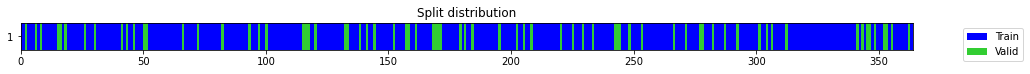

((#292) [63,188,136,323,350,134,235,62,164,36...],
 (#72) [120,72,18,6,132,225,266,243,306,202...])

In [ ]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

### 3. Training

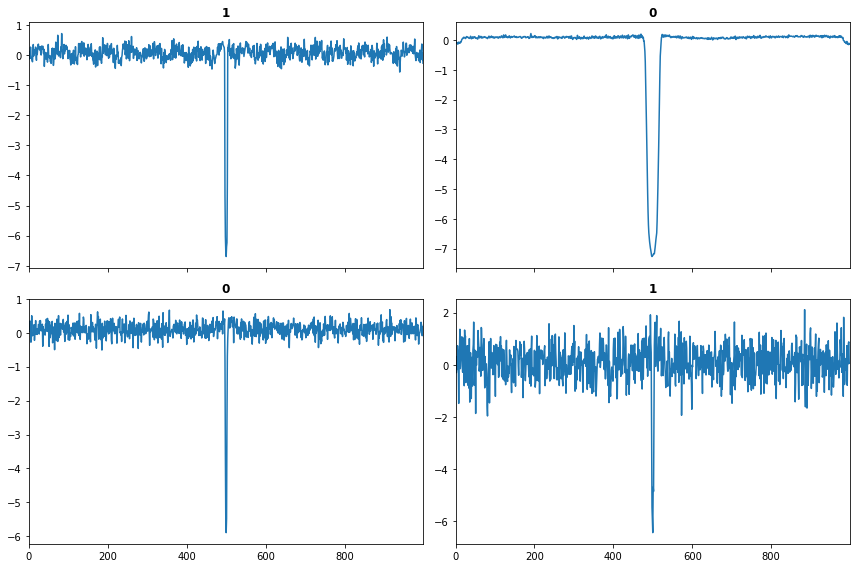

In [ ]:
bs = 4
n_epochs = 100
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())
dls.show_batch()

In [ ]:
model = ResNet(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

In [ ]:
learn.fit_one_cycle(250, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.627829,0.629802,0.680556,00:02
1,0.592991,0.586971,0.750000,00:02
2,0.561813,0.552378,0.736111,00:02
3,0.546161,0.566228,0.750000,00:03
4,0.524083,0.547242,0.763889,00:02
5,0.522034,0.526103,0.763889,00:02
6,0.546752,0.548800,0.708333,00:02
7,0.509260,0.533992,0.750000,00:01
8,0.533364,0.494512,0.750000,00:01
9,0.499789,0.484623,0.763889,00:01


Path('models/stage1.pth')

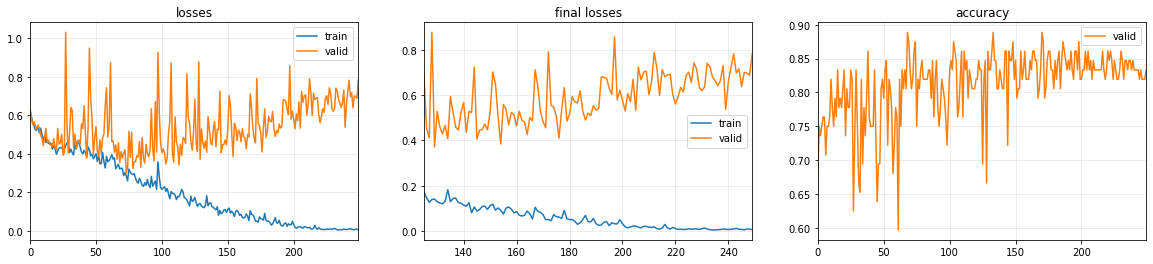

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [ ]:
del learn, dsets, dls

In [ ]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:4, vars:1, len:1000, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 1, 1, 1], device='cuda:0'))

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

In [ ]:
(valid_targets == valid_preds).float().mean()

tensor(0.8333)

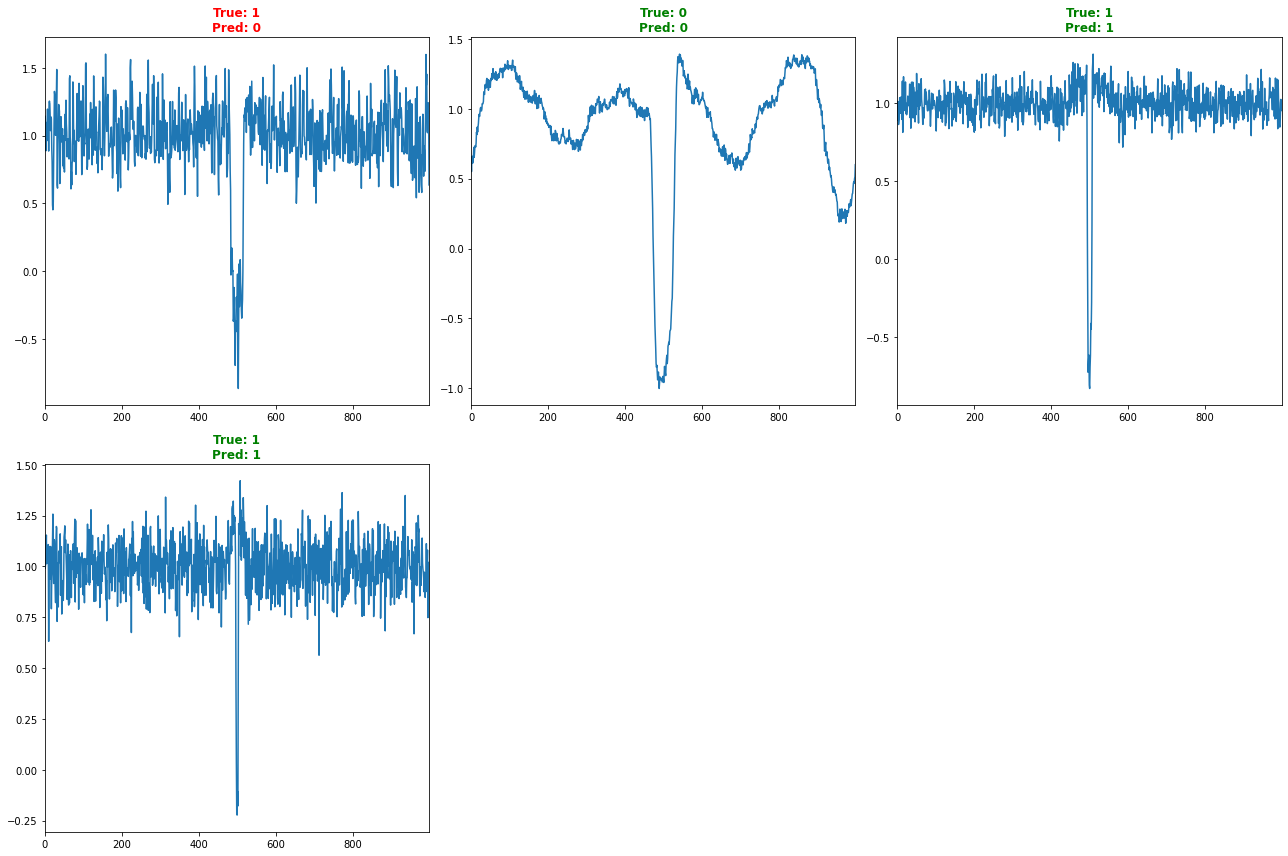

In [ ]:
learn.show_results()


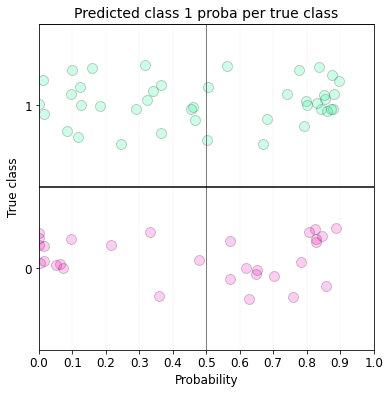

In [ ]:
learn.show_probas()

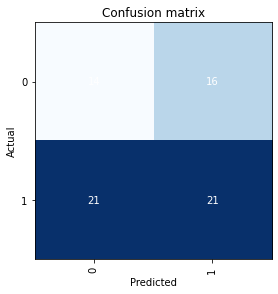

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### 4. Testing

In [ ]:
# Labeled test data

X, y = df2xy(df_test, target_col='target')
test_eq(X.shape, (df_test.shape[0], 1, df_test.shape[1]-1))
test_eq(y.shape, (df_test.shape[0], ))


test_ds = valid_dl.dataset.add_test(X, y)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:4, vars:1, len:1000, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 1, 0, 0], device='cuda:0'))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')


accuracy:   0.527473
